In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model import RidgeRegression
from selection import KFoldCV, NestedCV

In [2]:
def get_weights(data, target, model, name):
    val = data.columns.values.tolist()
    val.remove(target)
    return pd.DataFrame(data=model.get_weight(), index=val, columns=[name])

Carichiamo i dataset elaborati ottenuti dal notebook elaboration e definiamo la funzione di loss

In [3]:
def quadratic_loss(y_true, y_pred):
    return (y_true-y_pred)**2

dataA = ("base", pd.read_pickle("./base.pkl"))
dataB = ("base no out", pd.read_pickle("./base_no_out.pkl"))
dataC = ("add features", pd.read_pickle("./add_features.pkl"))
dataD = ("log", pd.read_pickle("./log.pkl"))
dataE = ("removed", pd.read_pickle("./removed.pkl"))

dataA_PCA = ("PCA base", pd.read_pickle("./PCAbase.pkl"))
dataB_PCA = ("PCA base no out", pd.read_pickle("./PCAbase_no_out.pkl"))
dataC_PCA = ("PCA add features", pd.read_pickle("./PCAadd_features.pkl"))
dataD_PCA = ("PCA log", pd.read_pickle("./PCAlog.pkl"))
dataE_PCA = ("PCA removed", pd.read_pickle("./PCAremoved.pkl"))

Definiamo il numero di fold e l'insieme di iperparemtri

In [4]:
folds = 10
kfolds = KFoldCV(folds, print=False, shuffle = 100)
alfas = np.logspace(-4, 3, 20)
alfas

array([1.00000000e-04, 2.33572147e-04, 5.45559478e-04, 1.27427499e-03,
       2.97635144e-03, 6.95192796e-03, 1.62377674e-02, 3.79269019e-02,
       8.85866790e-02, 2.06913808e-01, 4.83293024e-01, 1.12883789e+00,
       2.63665090e+00, 6.15848211e+00, 1.43844989e+01, 3.35981829e+01,
       7.84759970e+01, 1.83298071e+02, 4.28133240e+02, 1.00000000e+03])

## Training dei dataset e valutiamo i risultati MSE con cross validation

Facciamo training del modello di regressione e valutiamo i risultati con cross validation

In [7]:
def valuate(datasets, alfas, selection, model):
    res = []
    for d in datasets:
        print(d[0])
        errors = []
        for alfa in alfas:
            ridge = model(alfa=alfa)
            
            err = round(selection.cross_validate(ridge, d[1], "median_house_value", quadratic_loss), 10)
            print("{}\t{}".format(alfa, err))
            errors.append(err)
        min_value = min(errors)
        best_alfa = alfas[errors.index(min_value)]
        print("best alfa:\t{}".format(best_alfa))
        print("best value:\t{}\n".format(min_value))
        res.append(pd.DataFrame(data=errors, columns=[d[0]], index= alfas))
    
    return pd.concat(res, axis = 1)

In [8]:
datasets = [dataA, dataB, dataC, dataD, dataE]
base = valuate(datasets, alfas, kfolds, RidgeRegression)
base

base
0.0001	4736461508.756783
0.00023357214690901214	4736461506.330347
0.000545559478116852	4736461500.663341
0.0012742749857031334	4736461487.429343
0.002976351441631319	4736461456.532305
0.0069519279617756054	4736461384.441263
0.01623776739188721	4736461216.47039
0.0379269019073225	4736460826.394218
0.08858667904100823	4736459927.597213
0.2069138081114788	4736457895.415789
0.4832930238571752	4736453515.0302305
1.1288378916846884	4736445279.569987
2.6366508987303554	4736436906.374606
6.1584821106602545	4736476278.886835
14.38449888287663	4736885603.516446
33.59818286283781	4739522776.575172
78.47599703514607	4754271731.973348
183.29807108324337	4829374547.433457
428.1332398719387	5168746111.813508
1000.0	6435299880.7276945
best alfa:	2.6366508987303554
best value:	4736436906.374606

base no out
0.0001	3318694136.8546124
0.00023357214690901214	3318694135.8792605
0.000545559478116852	3318694133.6016207
0.0012742749857031334	3318694128.2844553
0.002976351441631319	3318694115.8801484
0.00

,base,base no out,add features,log,removed
0.000100,4.736462e+09,3.318694e+09,3.278886e+09,5.181220e+09,3.622858e+09
0.000234,4.736462e+09,3.318694e+09,3.278886e+09,5.181220e+09,3.622858e+09
0.000546,4.736462e+09,3.318694e+09,3.278886e+09,5.181220e+09,3.622858e+09
0.001274,4.736461e+09,3.318694e+09,3.278886e+09,5.181220e+09,3.622858e+09
0.002976,4.736461e+09,3.318694e+09,3.278886e+09,5.181220e+09,3.622858e+09
0.006952,4.736461e+09,3.318694e+09,3.278886e+09,5.181220e+09,3.622858e+09
0.016238,4.736461e+09,3.318694e+09,3.278886e+09,5.181220e+09,3.622858e+09
0.037927,4.736461e+09,3.318694e+09,3.278885e+09,5.181220e+09,3.622859e+09
0.088587,4.736460e+09,3.318694e+09,3.278885e+09,5.181220e+09,3.622859e+09
0.206914,4.736458e+09,3.318693e+09,3.278884e+09,5.181220e+09,3.622859e+09


Dagli esperimenti il dataset con i risultati più promettenti è il C

Controlliamo che i risultati siano in linea con quelli ottenuti con le funzioni di sklearn

In [7]:
d = dataC[1]
y = d["median_house_value"]
X = d.drop(["median_house_value"], axis=1)

In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
mlf = Ridge(solver='cholesky')

parameters = {"alpha":alfas}
clf = GridSearchCV(mlf, param_grid=parameters, scoring='neg_mean_squared_error',cv=10, n_jobs=-1)
clf.fit(X, y)

GridSearchCV(cv=10, estimator=Ridge(solver='cholesky'), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 2.33572147e-04, 5.45559478e-04, 1.27427499e-03,
       2.97635144e-03, 6.95192796e-03, 1.62377674e-02, 3.79269019e-02,
       8.85866790e-02, 2.06913808e-01, 4.83293024e-01, 1.12883789e+00,
       2.63665090e+00, 6.15848211e+00, 1.43844989e+01, 3.35981829e+01,
       7.84759970e+01, 1.83298071e+02, 4.28133240e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [9]:
best_alpha = "{0:.10f}".format(clf.best_params_['alpha'])
print("Best alpha: ", clf.best_params_['alpha'])
print("Best MSE:", -clf.best_score_)

Best alpha:  428.1332398719387
Best MSE: 3729703804.6802087


## Proviamo con PCA 

In [9]:
datasets = [dataA_PCA, dataB_PCA, dataC_PCA, dataD_PCA, dataE_PCA]
pca = valuate(datasets, alfas, kfolds, RidgeRegression)
pca

PCA base
0.0001	48727969838.44842
0.00023357214690901214	48727969838.29896
0.000545559478116852	48727969837.94989
0.0012742749857031334	48727969837.13452
0.002976351441631319	48727969835.23013
0.0069519279617756054	48727969830.78235
0.01623776739188721	48727969820.39494
0.0379269019073225	48727969796.140625
0.08858667904100823	48727969739.53226
0.2069138081114788	48727969607.54449
0.4832930238571752	48727969300.53183
1.1288378916846884	48727968590.38667
2.6366508987303554	48727966969.598724
6.1584821106602545	48727963390.62757
14.38449888287663	48727956157.74246
33.59818286283781	48727945393.63661
78.47599703514607	48727953486.72516
183.29807108324337	48728151097.738716
428.1332398719387	48729555278.61249
1000.0	48737590891.71329
best alfa:	33.59818286283781
best value:	48727945393.63661

PCA base no out
0.0001	39168991736.806
0.00023357214690901214	39168991736.7183
0.000545559478116852	39168991736.51342
0.0012742749857031334	39168991736.034935
0.002976351441631319	39168991734.91732
0.

,PCA base,PCA base no out,PCA add features,PCA log,PCA removed
0.000100,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.000234,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.000546,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.001274,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.002976,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.006952,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.016238,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.037927,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.088587,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10
0.206914,4.872797e+10,3.916899e+10,3.931643e+10,4.911825e+10,3.941863e+10


Ancora una volta C si rivela essere il migliore, anche se il MSE aumenta di un ordine di magnitudine. Notare come nei casi B e C si ottengano risultati molto simili a quelli di E; penso che questo sia dovuto al fatto che la PCA applica una sorta di feature selection, cosa che è stata gia fatta nell ultimo caso

Confrontiamo i risultati tra le versioni base e quelle con PCA

In [11]:
pd.concat([base, pca], axis = 1)

,base,base no out,add features,log,removed,PCA base,PCA base no out,PCA add features,PCA log,PCA removed
0.000100,5.388392e+09,3.833118e+09,3.770213e+09,5.940865e+09,4.233503e+09,5.985531e+10,4.924501e+10,4.832645e+10,5.939878e+10,4.877665e+10
0.000234,5.388391e+09,3.833117e+09,3.770213e+09,5.940865e+09,4.233503e+09,5.985531e+10,4.924501e+10,4.832645e+10,5.939878e+10,4.877665e+10
0.000546,5.388391e+09,3.833117e+09,3.770212e+09,5.940864e+09,4.233502e+09,5.985531e+10,4.924501e+10,4.832645e+10,5.939878e+10,4.877665e+10
0.001274,5.388389e+09,3.833115e+09,3.770210e+09,5.940863e+09,4.233500e+09,5.985531e+10,4.924501e+10,4.832645e+10,5.939878e+10,4.877665e+10
0.002976,5.388385e+09,3.833111e+09,3.770206e+09,5.940859e+09,4.233495e+09,5.985531e+10,4.924501e+10,4.832645e+10,5.939878e+10,4.877665e+10
0.006952,5.388376e+09,3.833102e+09,3.770197e+09,5.940851e+09,4.233484e+09,5.985531e+10,4.924501e+10,4.832645e+10,5.939878e+10,4.877665e+10
0.016238,5.388355e+09,3.833080e+09,3.770175e+09,5.940831e+09,4.233457e+09,5.985531e+10,4.924500e+10,4.832645e+10,5.939878e+10,4.877665e+10
0.037927,5.388305e+09,3.833029e+09,3.770124e+09,5.940784e+09,4.233395e+09,5.985530e+10,4.924499e+10,4.832644e+10,5.939877e+10,4.877664e+10
0.088587,5.388189e+09,3.832911e+09,3.770005e+09,5.940674e+09,4.233251e+09,5.985528e+10,4.924497e+10,4.832642e+10,5.939875e+10,4.877662e+10
0.206914,5.387919e+09,3.832634e+09,3.769727e+09,5.940419e+09,4.232915e+09,5.985523e+10,4.924492e+10,4.832638e+10,5.939872e+10,4.877656e+10


## Analisi su dataset C

In [5]:
d = dataC[1]

In [32]:
weights = []
errors = []
for alfa in alfas:
    ridge = RidgeRegression(alfa=alfa)
    err = kfolds.cross_validate(ridge, d, "median_house_value", quadratic_loss)
    weights.append(ridge.get_weight())
    errors.append(err)
tab = pd.DataFrame(weights, index=alfas)
tab

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0.000100,-50818.389234,-51967.672996,11407.941831,-3608.946962,14113.000755,-32888.054314,26229.905200,59694.656798,5922.929581,-3299.773191,13146.939862,199450.905307,167036.321708,189478.259242,196933.337909
0.000234,-50818.386129,-51967.668058,11407.942839,-3608.944678,14113.003001,-32888.051640,26229.898434,59694.656729,5922.928068,-3299.774772,13146.940040,199450.902731,167036.315422,189478.243020,196933.326243
0.000546,-50818.378878,-51967.656524,11407.945193,-3608.939341,14113.008246,-32888.045394,26229.882631,59694.656567,5922.924535,-3299.778466,13146.940457,199450.896713,167036.300739,189478.205130,196933.298994
0.001274,-50818.361942,-51967.629582,11407.950691,-3608.926877,14113.020497,-32888.030805,26229.845719,59694.656188,5922.916284,-3299.787094,13146.941431,199450.882657,167036.266444,189478.116628,196933.235347
0.002976,-50818.322383,-51967.566656,11407.963532,-3608.897764,14113.049113,-32887.996730,26229.759504,59694.655303,5922.897010,-3299.807245,13146.943706,199450.849826,167036.186339,189477.909913,196933.086687
0.006952,-50818.229986,-51967.419677,11407.993526,-3608.829766,14113.115948,-32887.917141,26229.558132,59694.653236,5922.851994,-3299.854312,13146.949019,199450.773142,167035.999238,189477.427085,196932.739459
0.016238,-50818.014173,-51967.076378,11408.063582,-3608.670941,14113.272038,-32887.731249,26229.087809,59694.648407,5922.746852,-3299.964247,13146.961430,199450.594028,167035.562224,189476.299346,196931.928436
0.037927,-50817.510100,-51966.274545,11408.227206,-3608.299981,14113.636530,-32887.297082,26227.989389,59694.637120,5922.501293,-3300.221012,13146.990422,199450.175666,167034.541492,189473.665319,196930.034135
0.088587,-50816.332762,-51964.401775,11408.609352,-3607.433571,14114.487373,-32886.283129,26225.424472,59694.610713,5921.927852,-3300.820680,13147.058156,199449.198475,167032.157409,189467.513278,196925.609707
0.206914,-50813.583031,-51960.027991,11409.501746,-3605.410157,14116.471946,-32883.915586,26219.437274,59694.548804,5920.589104,-3302.220996,13147.216460,199446.915947,167026.589191,189453.145539,196915.276190


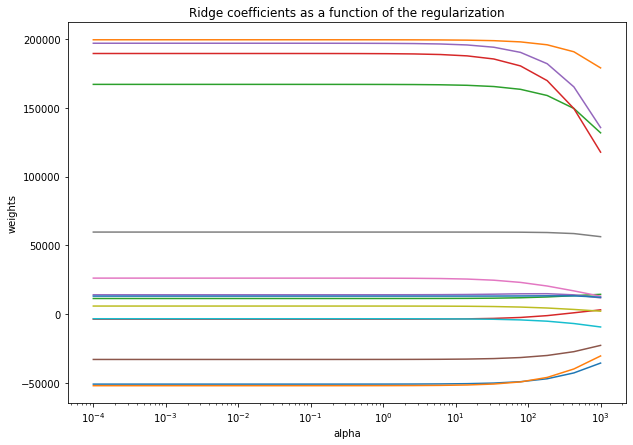

In [33]:
l = range(1, len(weights))
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot(alfas, weights)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.show()

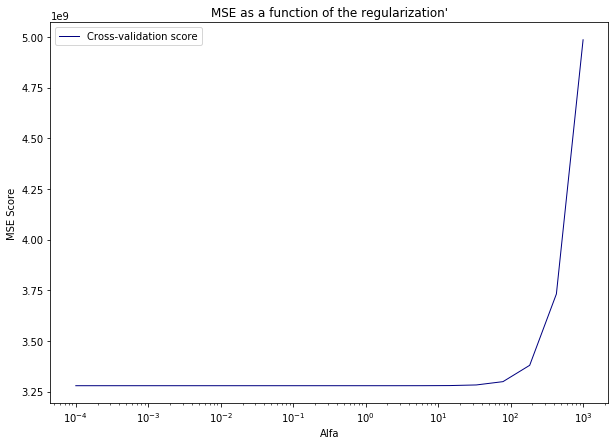

In [34]:
plt.figure(figsize=(10,7))
plt.title("MSE as a function of the regularization'")
plt.xlabel("Alfa")
plt.ylabel("MSE Score")
lw = 2.5
plt.semilogx(alfas, errors, label="Cross-validation score", color="navy", lw=1)
plt.legend(loc="best")
plt.show()

## Validazione

In [ ]:
folds = 5
kfolds = KFoldCV(folds, print=False, shuffle=100)


In [51]:
train_scores = []
test_scores = []
for alfa in alfas:
    ridge = RidgeRegression(alfa=alfa)
    err = kfolds.get_train_test_accuracy(ridge, d, "median_house_value", quadratic_loss)
    train_scores.append(err[0])
    test_scores.append(err[1])

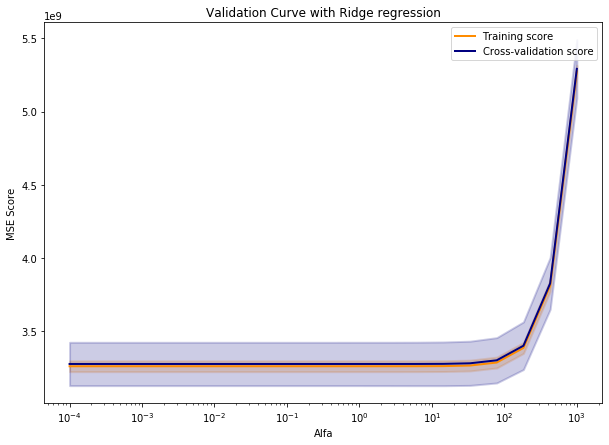

In [52]:
# Calculating mean and standard deviation of training score
train_scores_mean = np.mean(np.abs(train_scores), axis = 1)
train_scores_std = np.std(np.abs(train_scores), axis = 1)
 
# Calculating mean and standard deviation of testing score
test_scores_mean = np.mean(np.abs(test_scores), axis = 1)
test_scores_std = np.std(np.abs(test_scores), axis = 1)
plt.figure(figsize=(10,7))
plt.title("Validation Curve with Ridge regression")
plt.xlabel("Alfa")
plt.ylabel("MSE Score")
lw = 2
plt.semilogx(alfas, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(alfas, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(alfas, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(alfas, test_scores_mean - test_scores_std,  test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [92]:
best_alfa = 1.1288378916846884
ridge = RidgeRegression(alfa=best_alfa)

train_sizes=np.linspace(.1, 1.0, 20)

train_scores = []
test_scores = []
for n in train_sizes:
    d_frac = d.sample(frac=n, random_state=3)
    err = kfolds.get_train_test_accuracy(ridge, d_frac, "median_house_value", quadratic_loss)
    train_scores.append(err[0])
    test_scores.append(err[1])

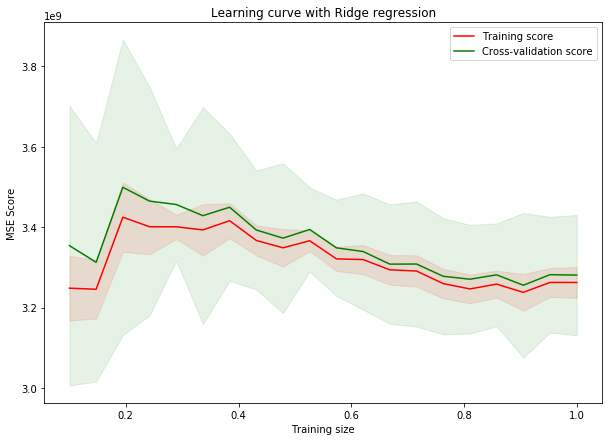

In [94]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10,7))
plt.title("Learning curve with Ridge regression")
plt.xlabel("Training size")
plt.ylabel("MSE Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

## Proviamo a fare una stima migliore dell'errore con Nested CV

Definiamo il numero di fold interni ed esterni e l'insieme di parametri

In [8]:
internal_folds = 5
folds = 10

Facciamo la stima dell'errore con Nested Cross Validation

In [52]:
errors_nested = list()
errors_best_model = list()
exp = range(1,21)

for i in exp:
    print(i)
    nestedKFolds = NestedCV(folds, internal_folds, shuffle=i, print=False)
    kfolds = KFoldCV(folds, print=False, shuffle=i)
    
    # compute cv on all alfas values
    kfold_estimate = list()
    for alfa in alfas:
        ridge = RidgeRegression(alfa=alfa)
        err = kfolds.cross_validate(ridge, d, "median_house_value", quadratic_loss)
        kfold_estimate.append(err)
    
    # get the best estimates on optimized paramter alfa
    m = min(kfold_estimate)
    errors_best_model.append(m)
    # nested estimates
    errors_nested.append(nestedKFolds.cross_validate(RidgeRegression, d, "median_house_value", quadratic_loss, alfas))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


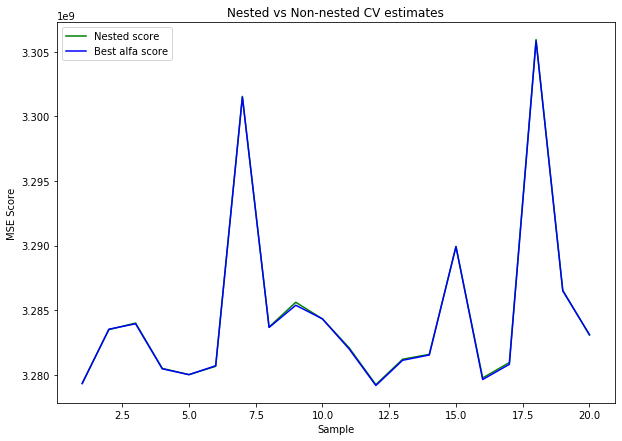

In [76]:
plt.figure(figsize=(10,7))
plt.title("Nested vs Non-nested CV estimates")
plt.xlabel("Individual Trial #")
plt.ylabel("MSE Score")
#plt.plot(exp, errors_kfold, color="r", label="K-Fold score")
plt.plot(exp, errors_nested, color="g", label="Nested score")
plt.plot(exp, errors_best_model, color="b", label="Best alfa score")
plt.legend(loc="best")
plt.show()

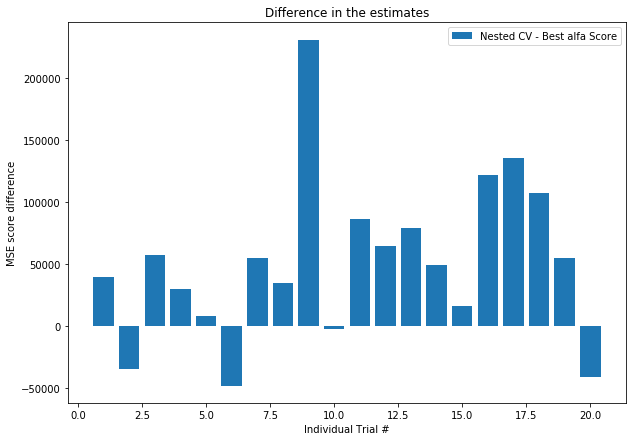

In [81]:
score_difference = [i-j for i, j in zip(errors_nested, errors_best_model)]

plt.figure(figsize=(10,7))
plt.title("Difference in the estimates")
plt.bar(exp, score_difference)
plt.xlabel("Individual Trial #")
plt.legend(["Nested CV - Best alfa Score"], loc="best")
plt.ylabel("MSE score difference")
plt.show()

Guardiamo la stabilità dei risultati considerando il valore di alfa e il risultato del modello corrispondente sia sull'inner che l'outer cv

In [23]:
nestedKFolds = NestedCV(folds, internal_folds, shuffle=100, print=True)
alfa_vals, inner, outer = nestedKFolds.get_inner_outer_estimates(RidgeRegression, d, "median_house_value", quadratic_loss, alfas)

In [24]:
data = {"Alfa":alfa_vals, "Inner estimates": inner, "Outer estimates": outer}
pd.DataFrame(data)

,Alfa,Inner estimates,Outer estimates
0,2.636651,3.240761e+09,3.636108e+09
1,0.088587,3.282688e+09,3.282003e+09
2,2.636651,3.319644e+09,2.951848e+09
3,1.128838,3.296926e+09,3.102969e+09
4,0.483293,3.267597e+09,3.372705e+09
5,1.128838,3.263994e+09,3.384840e+09
6,1.128838,3.282787e+09,3.270600e+09
7,2.636651,3.289614e+09,3.216046e+09
8,2.636651,3.280244e+09,3.292214e+09
9,1.128838,3.278800e+09,3.279144e+09


In [25]:
error = nestedKFolds.cross_validate(RidgeRegression, d, "median_house_value", quadratic_loss, alfas)

External fold num: 1
Testing with value 0.0001 with error : 3240783150.5910816
Testing with value 0.00023357214690901214 with error : 3240783147.4663982
Testing with value 0.000545559478116852 with error : 3240783140.1687946
Testing with value 0.0012742749857031334 with error : 3240783123.1279445
Testing with value 0.002976351441631319 with error : 3240783083.3488855
Testing with value 0.0069519279617756054 with error : 3240782990.5648556
Testing with value 0.01623776739188721 with error : 3240782774.5497737
Testing with value 0.0379269019073225 with error : 3240782273.831402
Testing with value 0.08858667904100823 with error : 3240781125.200065
Testing with value 0.2069138081114788 with error : 3240778556.3491707
Testing with value 0.4832930238571752 with error : 3240773177.9610643
Testing with value 1.1288378916846884 with error : 3240764002.626981
Testing with value 2.6366508987303554 with error : 3240760988.808213
Testing with value 6.1584821106602545 with error : 3240853652.562744


Testing with value 6.1584821106602545 with error : 3264113725.819906
Testing with value 14.38449888287663 with error : 3264908792.487797
Testing with value 33.59818286283781 with error : 3269545280.4548683
Testing with value 78.47599703514607 with error : 3294230861.9585876
Testing with value 183.29807108324337 with error : 3413901469.3038974
Testing with value 428.1332398719387 with error : 3915325182.85291
Testing with value 1000.0 with error : 5588240998.950981
The best parameter on interal folds is 1.1288378916846884, with error on external fold: 3384839940.4980016

External fold num: 7
Testing with value 0.0001 with error : 3282792259.865751
Testing with value 0.00023357214690901214 with error : 3282792258.4436607
Testing with value 0.000545559478116852 with error : 3282792255.1228423
Testing with value 0.0012742749857031334 with error : 3282792247.370617
Testing with value 0.002976351441631319 with error : 3282792229.2869625
Testing with value 0.0069519279617756054 with error : 3

In [26]:
error

3278847727.45735